In [ ]:
# Imports

In [1]:
import numpy as np
import librosa 
from os import environ
environ["MEDLEYDB_PATH"] = "/Datasets/MedleyDB"
import medleydb as mdb
import sklearn
import os
import sox
import tempfile as tmp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier

# Getting list of multitracks without bleed

In [6]:
loader = mdb.load_all_multitracks()
no_bleed_mtracks = []
for mtrack in loader:
    if not mtrack.has_bleed:
        no_bleed_mtracks.append(mtrack)

# Get instrument labels

In [7]:
valid_labels = mdb.multitrack.get_valid_instrument_labels()

# Loop over instrument to get files

In [8]:
file_dict = {}
for label in valid_labels:
    print label
    label_list = list(mdb.utils.get_files_for_instrument(label, multitrack_list = no_bleed_mtracks))
    if len(label_list) == 0:
        continue
    file_dict[label] = label_list


bagpipe
gu
bamboo flute
clarinet
cornet
chimes
harmonica
mandolin
timpani
sampler
piano
clean electric guitar
liuqin
beatboxing
triangle
pipe organ
marimba
erhu
alto saxophone
whistle
drum set
bass drum
banjo
male rapper
acoustic guitar
trumpet section
vibraphone
female rapper
sleigh bells
darbuka
concertina
electric piano
baritone saxophone
oud
tack piano
trombone
harp
tuba
tabla
doumbek
recorder
cabasa
guzheng
shaker
vocalists
viola section
male speaker
zhongruan
string section
cowbell
accordion
toms
dizi
double bass
bongo
flute section
cello section
brass section
tenor saxophone
kick drum
yangqin
english horn
conga
guiro
synthesizer
harpsichord
castanet
soprano saxophone
electric bass
oboe
violin section
xylophone
fx/processed sound
female speaker
scratches
french horn
dulcimer
auxiliary percussion
glockenspiel
cello
female singer
panpipes
male singer
gong
rattle
piccolo
euphonium
high hat
claps
violin
snare drum
trumpet
harmonium
horn section
clarinet section
electronic organ
ukule

In [10]:
for label in list(file_dict.keys()):
    print label
    print len(file_dict[label])
    print ""

darbuka
1

gu
1

toms
1

electric piano
3

distorted electric guitar
31

cello section
5

drum set
60

piccolo
4

baritone saxophone
1

bongo
1

bamboo flute
1

oud
2

tenor saxophone
2

claps
5

electric bass
58

tack piano
6

yangqin
6

trombone
3

violin
14

clarinet
8

flute
6

trumpet
7

tabla
14

horn section
2

harp
3

harmonica
2

mandolin
5

timpani
6

tuba
2

tambourine
1

french horn section
3

synthesizer
47

doumbek
1

sampler
3

viola
6

piano
27

banjo
2

liuqin
2

drum machine
17

male singer
41

soprano saxophone
1

guzheng
5

shaker
1

brass section
8

clarinet section
3

vocalists
30

viola section
4

violin section
17

fx/processed sound
41

zhongruan
3

erhu
6

trombone section
1

alto saxophone
1

cymbal
7

bass clarinet
1

string section
5

flute section
2

scratches
1

french horn
4

auxiliary percussion
16

glockenspiel
3

bass drum
1

oboe
5

clean electric guitar
52

male rapper
6

acoustic guitar
18

accordion
5

trumpet section
5

vibraphone
8

gong
2

bass

# Compute MFCC

In [ ]:
mfcc_list = []
label_list = []
mfcc_dict = {}
label_index = 0

# loop over instrument labels
for label in list(file_dict.keys()):
    print label
    print len(file_dict[label])
    
    # loop over files for instruments
    for fpath in file_dict[label]:
        print fpath
        # normalizing volume, removing silence
        temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
        tfm = sox.Transformer()
        tfm.norm(db_level=-6)
        tfm.silence()
        tfm.build(fpath, temp_fpath.name)
        
        # load audio
        y, fs = librosa.load(temp_fpath.name)
        
        # compute MFCCs
        M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)
        
        # creating labels
        lab = np.zeros((len(M[0]), )) + label_index
        mfcc_list.append(M)
        label_list.append(lab)
        
    print ""
    label_index = label_index + 1

mfcc_matrix = np.hstack(mfcc_list).T
label_matrix = np.hstack(label_list)

darbuka
1
/Datasets/MedleyDB/Audio/KarimDouaidy_Hopscotch/KarimDouaidy_Hopscotch_STEMS/KarimDouaidy_Hopscotch_STEM_04.wav



gu
1
/Datasets/MedleyDB/Audio/MusicDelta_ChineseXinJing/MusicDelta_ChineseXinJing_STEMS/MusicDelta_ChineseXinJing_STEM_02.wav



toms
1
/Datasets/MedleyDB/Audio/MusicDelta_InTheHalloftheMountainKing/MusicDelta_InTheHalloftheMountainKing_STEMS/MusicDelta_InTheHalloftheMountainKing_STEM_16.wav



electric piano
3
/Datasets/MedleyDB/Audio/MusicDelta_FunkJazz/MusicDelta_FunkJazz_STEMS/MusicDelta_FunkJazz_STEM_03.wav
/Datasets/MedleyDB/Audio/MusicDelta_FusionJazz/MusicDelta_FusionJazz_STEMS/MusicDelta_FusionJazz_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_LatinJazz/MusicDelta_LatinJazz_STEMS/MusicDelta_LatinJazz_STEM_03.wav


distorted electric guitar
31
/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_03.wav
/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_04.wav


/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_06.wav


/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_07.wav


/Datasets/MedleyDB/Audio/AvaLuna_Waterduct/AvaLuna_Waterduct_STEMS/AvaLuna_Waterduct_STEM_05.wav


/Datasets/MedleyDB/Audio/BigTroubles_Phantom/BigTroubles_Phantom_STEMS/BigTroubles_Phantom_STEM_03.wav


/Datasets/MedleyDB/Audio/BigTroubles_Phantom/BigTroubles_Phantom_STEMS/BigTroubles_Phantom_STEM_05.wav


/Datasets/MedleyDB/Audio/BigTroubles_Phantom/BigTroubles_Phantom_STEMS/BigTroubles_Phantom_STEM_07.wav


/Datasets/MedleyDB/Audio/Creepoid_OldTree/Creepoid_OldTree_STEMS/Creepoid_OldTree_STEM_05.wav


/Datasets/MedleyDB/Audio/Creepoid_OldTree/Creepoid_OldTree_STEMS/Creepoid_OldTree_STEM_06.wav


/Datasets/MedleyDB/Audio/EthanHein_GirlOnABridge/EthanHein_GirlOnABridge_STEMS/EthanHein_GirlOnABridge_STEM_05.wav


/Datasets/MedleyDB/Audio/FacesOnFilm_WaitingForGa/FacesOnFilm_WaitingForGa_STEMS/FacesOnFilm_WaitingForGa_STEM_06.wav


/Datasets/MedleyDB/Audio/HopAlong_SisterCities/HopAlong_SisterCities_STEMS/HopAlong_SisterCities_STEM_06.wav


/Datasets/MedleyDB/Audio/HopAlong_SisterCities/HopAlong_SisterCities_STEMS/HopAlong_SisterCities_STEM_08.wav


/Datasets/MedleyDB/Audio/Meaxic_TakeAStep/Meaxic_TakeAStep_STEMS/Meaxic_TakeAStep_STEM_03.wav


/Datasets/MedleyDB/Audio/Meaxic_YouListen/Meaxic_YouListen_STEMS/Meaxic_YouListen_STEM_06.wav


/Datasets/MedleyDB/Audio/MusicDelta_80sRock/MusicDelta_80sRock_STEMS/MusicDelta_80sRock_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Britpop/MusicDelta_Britpop_STEMS/MusicDelta_Britpop_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Grunge/MusicDelta_Grunge_STEMS/MusicDelta_Grunge_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Grunge/MusicDelta_Grunge_STEMS/MusicDelta_Grunge_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_Hendrix/MusicDelta_Hendrix_STEMS/MusicDelta_Hendrix_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Punk/MusicDelta_Punk_STEMS/MusicDelta_Punk_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Rockabilly/MusicDelta_Rockabilly_STEMS/MusicDelta_Rockabilly_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_SpeedMetal/MusicDelta_SpeedMetal_STEMS/MusicDelta_SpeedMetal_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_SpeedMetal/MusicDelta_SpeedMetal_STEMS/MusicDelta_SpeedMetal_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_Zeppelin/MusicDelta_Zeppelin_STEMS/MusicDelta_Zeppelin_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Zeppelin/MusicDelta_Zeppelin_STEMS/MusicDelta_Zeppelin_STEM_04.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Animoog/TablaBreakbeatScience_Animoog_STEMS/TablaBreakbeatScience_Animoog_STEM_03.wav


/Datasets/MedleyDB/Audio/TheScarletBrand_LesFleursDuMal/TheScarletBrand_LesFleursDuMal_STEMS/TheScarletBrand_LesFleursDuMal_STEM_04.wav


/Datasets/MedleyDB/Audio/TheScarletBrand_LesFleursDuMal/TheScarletBrand_LesFleursDuMal_STEMS/TheScarletBrand_LesFleursDuMal_STEM_05.wav


/Datasets/MedleyDB/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_04.wav


cello section
5
/Datasets/MedleyDB/Audio/MatthewEntwistle_FairerHopes/MatthewEntwistle_FairerHopes_STEMS/MatthewEntwistle_FairerHopes_STEM_02.wav
/Datasets/MedleyDB/Audio/MatthewEntwistle_FairerHopes/MatthewEntwistle_FairerHopes_STEMS/MatthewEntwistle_FairerHopes_STEM_03.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_FairerHopes/MatthewEntwistle_FairerHopes_STEMS/MatthewEntwistle_FairerHopes_STEM_04.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_TheArch/MatthewEntwistle_TheArch_STEMS/MatthewEntwistle_TheArch_STEM_05.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_TheArch/MatthewEntwistle_TheArch_STEMS/MatthewEntwistle_TheArch_STEM_06.wav


drum set
60
/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_02.wav
/Datasets/MedleyDB/Audio/AimeeNorwich_Child/AimeeNorwich_Child_STEMS/AimeeNorwich_Child_STEM_01.wav


/Datasets/MedleyDB/Audio/AimeeNorwich_Flying/AimeeNorwich_Flying_STEMS/AimeeNorwich_Flying_STEM_01.wav


/Datasets/MedleyDB/Audio/AlexanderRoss_GoodbyeBolero/AlexanderRoss_GoodbyeBolero_STEMS/AlexanderRoss_GoodbyeBolero_STEM_05.wav


/Datasets/MedleyDB/Audio/AlexanderRoss_VelvetCurtain/AlexanderRoss_VelvetCurtain_STEMS/AlexanderRoss_VelvetCurtain_STEM_05.wav


/Datasets/MedleyDB/Audio/Auctioneer_OurFutureFaces/Auctioneer_OurFutureFaces_STEMS/Auctioneer_OurFutureFaces_STEM_04.wav


/Datasets/MedleyDB/Audio/AvaLuna_Waterduct/AvaLuna_Waterduct_STEMS/AvaLuna_Waterduct_STEM_04.wav


/Datasets/MedleyDB/Audio/BigTroubles_Phantom/BigTroubles_Phantom_STEMS/BigTroubles_Phantom_STEM_02.wav


/Datasets/MedleyDB/Audio/CelestialShore_DieForUs/CelestialShore_DieForUs_STEMS/CelestialShore_DieForUs_STEM_06.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_AirTraffic/ClaraBerryAndWooldog_AirTraffic_STEMS/ClaraBerryAndWooldog_AirTraffic_STEM_01.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_Stella/ClaraBerryAndWooldog_Stella_STEMS/ClaraBerryAndWooldog_Stella_STEM_01.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_WaltzForMyVictims/ClaraBerryAndWooldog_WaltzForMyVictims_STEMS/ClaraBerryAndWooldog_WaltzForMyVictims_STEM_01.wav


/Datasets/MedleyDB/Audio/Creepoid_OldTree/Creepoid_OldTree_STEMS/Creepoid_OldTree_STEM_04.wav


/Datasets/MedleyDB/Audio/DreamersOfTheGhetto_HeavyLove/DreamersOfTheGhetto_HeavyLove_STEMS/DreamersOfTheGhetto_HeavyLove_STEM_05.wav


/Datasets/MedleyDB/Audio/EthanHein_BluesForNofi/EthanHein_BluesForNofi_STEMS/EthanHein_BluesForNofi_STEM_01.wav


/Datasets/MedleyDB/Audio/FacesOnFilm_WaitingForGa/FacesOnFilm_WaitingForGa_STEMS/FacesOnFilm_WaitingForGa_STEM_04.wav


/Datasets/MedleyDB/Audio/HezekiahJones_BorrowedHeart/HezekiahJones_BorrowedHeart_STEMS/HezekiahJones_BorrowedHeart_STEM_09.wav


/Datasets/MedleyDB/Audio/HopAlong_SisterCities/HopAlong_SisterCities_STEMS/HopAlong_SisterCities_STEM_04.wav


/Datasets/MedleyDB/Audio/InvisibleFamiliars_DisturbingWildlife/InvisibleFamiliars_DisturbingWildlife_STEMS/InvisibleFamiliars_DisturbingWildlife_STEM_04.wav


/Datasets/MedleyDB/Audio/Lushlife_ToynbeeSuite/Lushlife_ToynbeeSuite_STEMS/Lushlife_ToynbeeSuite_STEM_07.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_DontYouEver/MatthewEntwistle_DontYouEver_STEMS/MatthewEntwistle_DontYouEver_STEM_04.wav


/Datasets/MedleyDB/Audio/Meaxic_TakeAStep/Meaxic_TakeAStep_STEMS/Meaxic_TakeAStep_STEM_05.wav


/Datasets/MedleyDB/Audio/Meaxic_YouListen/Meaxic_YouListen_STEMS/Meaxic_YouListen_STEM_07.wav


/Datasets/MedleyDB/Audio/MusicDelta_80sRock/MusicDelta_80sRock_STEMS/MusicDelta_80sRock_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beatles/MusicDelta_Beatles_STEMS/MusicDelta_Beatles_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_BebopJazz/MusicDelta_BebopJazz_STEMS/MusicDelta_BebopJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Britpop/MusicDelta_Britpop_STEMS/MusicDelta_Britpop_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_CoolJazz/MusicDelta_CoolJazz_STEMS/MusicDelta_CoolJazz_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Country1/MusicDelta_Country1_STEMS/MusicDelta_Country1_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Country2/MusicDelta_Country2_STEMS/MusicDelta_Country2_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Disco/MusicDelta_Disco_STEMS/MusicDelta_Disco_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_FreeJazz/MusicDelta_FreeJazz_STEMS/MusicDelta_FreeJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_FunkJazz/MusicDelta_FunkJazz_STEMS/MusicDelta_FunkJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_FusionJazz/MusicDelta_FusionJazz_STEMS/MusicDelta_FusionJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Gospel/MusicDelta_Gospel_STEMS/MusicDelta_Gospel_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Grunge/MusicDelta_Grunge_STEMS/MusicDelta_Grunge_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Hendrix/MusicDelta_Hendrix_STEMS/MusicDelta_Hendrix_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_LatinJazz/MusicDelta_LatinJazz_STEMS/MusicDelta_LatinJazz_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Punk/MusicDelta_Punk_STEMS/MusicDelta_Punk_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Reggae/MusicDelta_Reggae_STEMS/MusicDelta_Reggae_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Rock/MusicDelta_Rock_STEMS/MusicDelta_Rock_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Rockabilly/MusicDelta_Rockabilly_STEMS/MusicDelta_Rockabilly_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Shadows/MusicDelta_Shadows_STEMS/MusicDelta_Shadows_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_SpeedMetal/MusicDelta_SpeedMetal_STEMS/MusicDelta_SpeedMetal_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_SwingJazz/MusicDelta_SwingJazz_STEMS/MusicDelta_SwingJazz_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Zeppelin/MusicDelta_Zeppelin_STEMS/MusicDelta_Zeppelin_STEM_02.wav


/Datasets/MedleyDB/Audio/NightPanther_Fire/NightPanther_Fire_STEMS/NightPanther_Fire_STEM_05.wav


/Datasets/MedleyDB/Audio/PortStWillow_StayEven/PortStWillow_StayEven_STEMS/PortStWillow_StayEven_STEM_03.wav


/Datasets/MedleyDB/Audio/PortStWillow_StayEven/PortStWillow_StayEven_STEMS/PortStWillow_StayEven_STEM_04.wav


/Datasets/MedleyDB/Audio/SecretMountains_HighHorse/SecretMountains_HighHorse_STEMS/SecretMountains_HighHorse_STEM_04.wav


/Datasets/MedleyDB/Audio/Snowmine_Curfews/Snowmine_Curfews_STEMS/Snowmine_Curfews_STEM_05.wav


/Datasets/MedleyDB/Audio/StevenClark_Bounty/StevenClark_Bounty_STEMS/StevenClark_Bounty_STEM_05.wav


/Datasets/MedleyDB/Audio/StrandOfOaks_Spacestation/StrandOfOaks_Spacestation_STEMS/StrandOfOaks_Spacestation_STEM_03.wav


/Datasets/MedleyDB/Audio/SweetLights_YouLetMeDown/SweetLights_YouLetMeDown_STEMS/SweetLights_YouLetMeDown_STEM_06.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_CaptainSky/TablaBreakbeatScience_CaptainSky_STEMS/TablaBreakbeatScience_CaptainSky_STEM_01.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MiloVsMongo/TablaBreakbeatScience_MiloVsMongo_STEMS/TablaBreakbeatScience_MiloVsMongo_STEM_01.wav


/Datasets/MedleyDB/Audio/TheDistricts_Vermont/TheDistricts_Vermont_STEMS/TheDistricts_Vermont_STEM_03.wav


/Datasets/MedleyDB/Audio/TheScarletBrand_LesFleursDuMal/TheScarletBrand_LesFleursDuMal_STEMS/TheScarletBrand_LesFleursDuMal_STEM_01.wav


/Datasets/MedleyDB/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_03.wav


piccolo
4
/Datasets/MedleyDB/Audio/MatthewEntwistle_TheArch/MatthewEntwistle_TheArch_STEMS/MatthewEntwistle_TheArch_STEM_11.wav
/Datasets/MedleyDB/Audio/MusicDelta_GriegTrolltog/MusicDelta_GriegTrolltog_STEMS/MusicDelta_GriegTrolltog_STEM_07.wav


/Datasets/MedleyDB/Audio/MusicDelta_GriegTrolltog/MusicDelta_GriegTrolltog_STEMS/MusicDelta_GriegTrolltog_STEM_08.wav


/Datasets/MedleyDB/Audio/MusicDelta_InTheHalloftheMountainKing/MusicDelta_InTheHalloftheMountainKing_STEMS/MusicDelta_InTheHalloftheMountainKing_STEM_06.wav


baritone saxophone
1
/Datasets/MedleyDB/Audio/MusicDelta_CoolJazz/MusicDelta_CoolJazz_STEMS/MusicDelta_CoolJazz_STEM_04.wav



bongo
1
/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_05.wav



bamboo flute
1
/Datasets/MedleyDB/Audio/MatthewEntwistle_TheArch/MatthewEntwistle_TheArch_STEMS/MatthewEntwistle_TheArch_STEM_10.wav



oud
2
/Datasets/MedleyDB/Audio/KarimDouaidy_Hopscotch/KarimDouaidy_Hopscotch_STEMS/KarimDouaidy_Hopscotch_STEM_07.wav
/Datasets/MedleyDB/Audio/KarimDouaidy_Yatora/KarimDouaidy_Yatora_STEMS/KarimDouaidy_Yatora_STEM_03.wav


tenor saxophone
2
/Datasets/MedleyDB/Audio/MusicDelta_BebopJazz/MusicDelta_BebopJazz_STEMS/MusicDelta_BebopJazz_STEM_04.wav
/Datasets/MedleyDB/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_04.wav


claps
5
/Datasets/MedleyDB/Audio/InvisibleFamiliars_DisturbingWildlife/InvisibleFamiliars_DisturbingWildlife_STEMS/InvisibleFamiliars_DisturbingWildlife_STEM_02.wav
/Datasets/MedleyDB/Audio/KarimDouaidy_Hopscotch/KarimDouaidy_Hopscotch_STEMS/KarimDouaidy_Hopscotch_STEM_03.wav


/Datasets/MedleyDB/Audio/Lushlife_ToynbeeSuite/Lushlife_ToynbeeSuite_STEMS/Lushlife_ToynbeeSuite_STEM_03.wav


/Datasets/MedleyDB/Audio/MusicDelta_Gospel/MusicDelta_Gospel_STEMS/MusicDelta_Gospel_STEM_05.wav


/Datasets/MedleyDB/Audio/SweetLights_YouLetMeDown/SweetLights_YouLetMeDown_STEMS/SweetLights_YouLetMeDown_STEM_05.wav


electric bass
58
/Datasets/MedleyDB/Audio/AClassicEducation_NightOwl/AClassicEducation_NightOwl_STEMS/AClassicEducation_NightOwl_STEM_01.wav
/Datasets/MedleyDB/Audio/AimeeNorwich_Child/AimeeNorwich_Child_STEMS/AimeeNorwich_Child_STEM_02.wav


/Datasets/MedleyDB/Audio/AimeeNorwich_Flying/AimeeNorwich_Flying_STEMS/AimeeNorwich_Flying_STEM_03.wav


/Datasets/MedleyDB/Audio/AlexanderRoss_GoodbyeBolero/AlexanderRoss_GoodbyeBolero_STEMS/AlexanderRoss_GoodbyeBolero_STEM_04.wav


/Datasets/MedleyDB/Audio/AlexanderRoss_VelvetCurtain/AlexanderRoss_VelvetCurtain_STEMS/AlexanderRoss_VelvetCurtain_STEM_04.wav


/Datasets/MedleyDB/Audio/Auctioneer_OurFutureFaces/Auctioneer_OurFutureFaces_STEMS/Auctioneer_OurFutureFaces_STEM_02.wav


/Datasets/MedleyDB/Audio/AvaLuna_Waterduct/AvaLuna_Waterduct_STEMS/AvaLuna_Waterduct_STEM_01.wav


/Datasets/MedleyDB/Audio/BigTroubles_Phantom/BigTroubles_Phantom_STEMS/BigTroubles_Phantom_STEM_01.wav


/Datasets/MedleyDB/Audio/CelestialShore_DieForUs/CelestialShore_DieForUs_STEMS/CelestialShore_DieForUs_STEM_03.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_AirTraffic/ClaraBerryAndWooldog_AirTraffic_STEMS/ClaraBerryAndWooldog_AirTraffic_STEM_03.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_Stella/ClaraBerryAndWooldog_Stella_STEMS/ClaraBerryAndWooldog_Stella_STEM_04.wav


/Datasets/MedleyDB/Audio/ClaraBerryAndWooldog_WaltzForMyVictims/ClaraBerryAndWooldog_WaltzForMyVictims_STEMS/ClaraBerryAndWooldog_WaltzForMyVictims_STEM_02.wav


/Datasets/MedleyDB/Audio/Creepoid_OldTree/Creepoid_OldTree_STEMS/Creepoid_OldTree_STEM_02.wav


/Datasets/MedleyDB/Audio/DreamersOfTheGhetto_HeavyLove/DreamersOfTheGhetto_HeavyLove_STEMS/DreamersOfTheGhetto_HeavyLove_STEM_01.wav


/Datasets/MedleyDB/Audio/EthanHein_BluesForNofi/EthanHein_BluesForNofi_STEMS/EthanHein_BluesForNofi_STEM_02.wav


/Datasets/MedleyDB/Audio/FacesOnFilm_WaitingForGa/FacesOnFilm_WaitingForGa_STEMS/FacesOnFilm_WaitingForGa_STEM_02.wav


/Datasets/MedleyDB/Audio/Grants_PunchDrunk/Grants_PunchDrunk_STEMS/Grants_PunchDrunk_STEM_02.wav


/Datasets/MedleyDB/Audio/HezekiahJones_BorrowedHeart/HezekiahJones_BorrowedHeart_STEMS/HezekiahJones_BorrowedHeart_STEM_04.wav


/Datasets/MedleyDB/Audio/HopAlong_SisterCities/HopAlong_SisterCities_STEMS/HopAlong_SisterCities_STEM_02.wav


/Datasets/MedleyDB/Audio/InvisibleFamiliars_DisturbingWildlife/InvisibleFamiliars_DisturbingWildlife_STEMS/InvisibleFamiliars_DisturbingWildlife_STEM_01.wav


/Datasets/MedleyDB/Audio/KarimDouaidy_Hopscotch/KarimDouaidy_Hopscotch_STEMS/KarimDouaidy_Hopscotch_STEM_01.wav


/Datasets/MedleyDB/Audio/KarimDouaidy_Yatora/KarimDouaidy_Yatora_STEMS/KarimDouaidy_Yatora_STEM_04.wav


/Datasets/MedleyDB/Audio/Lushlife_ToynbeeSuite/Lushlife_ToynbeeSuite_STEMS/Lushlife_ToynbeeSuite_STEM_08.wav


/Datasets/MedleyDB/Audio/Meaxic_TakeAStep/Meaxic_TakeAStep_STEMS/Meaxic_TakeAStep_STEM_01.wav


/Datasets/MedleyDB/Audio/Meaxic_YouListen/Meaxic_YouListen_STEMS/Meaxic_YouListen_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_80sRock/MusicDelta_80sRock_STEMS/MusicDelta_80sRock_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beatles/MusicDelta_Beatles_STEMS/MusicDelta_Beatles_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Britpop/MusicDelta_Britpop_STEMS/MusicDelta_Britpop_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Country1/MusicDelta_Country1_STEMS/MusicDelta_Country1_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Country2/MusicDelta_Country2_STEMS/MusicDelta_Country2_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Disco/MusicDelta_Disco_STEMS/MusicDelta_Disco_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_FunkJazz/MusicDelta_FunkJazz_STEMS/MusicDelta_FunkJazz_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_FusionJazz/MusicDelta_FusionJazz_STEMS/MusicDelta_FusionJazz_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Gospel/MusicDelta_Gospel_STEMS/MusicDelta_Gospel_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Grunge/MusicDelta_Grunge_STEMS/MusicDelta_Grunge_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Hendrix/MusicDelta_Hendrix_STEMS/MusicDelta_Hendrix_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_LatinJazz/MusicDelta_LatinJazz_STEMS/MusicDelta_LatinJazz_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Punk/MusicDelta_Punk_STEMS/MusicDelta_Punk_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Reggae/MusicDelta_Reggae_STEMS/MusicDelta_Reggae_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Rock/MusicDelta_Rock_STEMS/MusicDelta_Rock_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Rockabilly/MusicDelta_Rockabilly_STEMS/MusicDelta_Rockabilly_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Shadows/MusicDelta_Shadows_STEMS/MusicDelta_Shadows_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_SpeedMetal/MusicDelta_SpeedMetal_STEMS/MusicDelta_SpeedMetal_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Zeppelin/MusicDelta_Zeppelin_STEMS/MusicDelta_Zeppelin_STEM_01.wav


/Datasets/MedleyDB/Audio/NightPanther_Fire/NightPanther_Fire_STEMS/NightPanther_Fire_STEM_01.wav


/Datasets/MedleyDB/Audio/PortStWillow_StayEven/PortStWillow_StayEven_STEMS/PortStWillow_StayEven_STEM_10.wav


/Datasets/MedleyDB/Audio/SecretMountains_HighHorse/SecretMountains_HighHorse_STEMS/SecretMountains_HighHorse_STEM_01.wav


/Datasets/MedleyDB/Audio/Snowmine_Curfews/Snowmine_Curfews_STEMS/Snowmine_Curfews_STEM_02.wav


/Datasets/MedleyDB/Audio/StevenClark_Bounty/StevenClark_Bounty_STEMS/StevenClark_Bounty_STEM_02.wav


/Datasets/MedleyDB/Audio/StrandOfOaks_Spacestation/StrandOfOaks_Spacestation_STEMS/StrandOfOaks_Spacestation_STEM_01.wav


/Datasets/MedleyDB/Audio/SweetLights_YouLetMeDown/SweetLights_YouLetMeDown_STEMS/SweetLights_YouLetMeDown_STEM_02.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Animoog/TablaBreakbeatScience_Animoog_STEMS/TablaBreakbeatScience_Animoog_STEM_02.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_CaptainSky/TablaBreakbeatScience_CaptainSky_STEMS/TablaBreakbeatScience_CaptainSky_STEM_02.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_PhaseTransition/TablaBreakbeatScience_PhaseTransition_STEMS/TablaBreakbeatScience_PhaseTransition_STEM_03.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_WhoIsIt/TablaBreakbeatScience_WhoIsIt_STEMS/TablaBreakbeatScience_WhoIsIt_STEM_03.wav


/Datasets/MedleyDB/Audio/TheDistricts_Vermont/TheDistricts_Vermont_STEMS/TheDistricts_Vermont_STEM_01.wav


/Datasets/MedleyDB/Audio/TheScarletBrand_LesFleursDuMal/TheScarletBrand_LesFleursDuMal_STEMS/TheScarletBrand_LesFleursDuMal_STEM_02.wav


/Datasets/MedleyDB/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_01.wav


tack piano
6
/Datasets/MedleyDB/Audio/CelestialShore_DieForUs/CelestialShore_DieForUs_STEMS/CelestialShore_DieForUs_STEM_07.wav
/Datasets/MedleyDB/Audio/HeladoNegro_MitadDelMundo/HeladoNegro_MitadDelMundo_STEMS/HeladoNegro_MitadDelMundo_STEM_10.wav


/Datasets/MedleyDB/Audio/InvisibleFamiliars_DisturbingWildlife/InvisibleFamiliars_DisturbingWildlife_STEMS/InvisibleFamiliars_DisturbingWildlife_STEM_10.wav


/Datasets/MedleyDB/Audio/Snowmine_Curfews/Snowmine_Curfews_STEMS/Snowmine_Curfews_STEM_11.wav


/Datasets/MedleyDB/Audio/StrandOfOaks_Spacestation/StrandOfOaks_Spacestation_STEMS/StrandOfOaks_Spacestation_STEM_08.wav


/Datasets/MedleyDB/Audio/SweetLights_YouLetMeDown/SweetLights_YouLetMeDown_STEMS/SweetLights_YouLetMeDown_STEM_11.wav


yangqin
6
/Datasets/MedleyDB/Audio/MusicDelta_ChineseChaoZhou/MusicDelta_ChineseChaoZhou_STEMS/MusicDelta_ChineseChaoZhou_STEM_04.wav
/Datasets/MedleyDB/Audio/MusicDelta_ChineseDrama/MusicDelta_ChineseDrama_STEMS/MusicDelta_ChineseDrama_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_ChineseHenan/MusicDelta_ChineseHenan_STEMS/MusicDelta_ChineseHenan_STEM_05.wav


/Datasets/MedleyDB/Audio/MusicDelta_ChineseJiangNan/MusicDelta_ChineseJiangNan_STEMS/MusicDelta_ChineseJiangNan_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_ChineseXinJing/MusicDelta_ChineseXinJing_STEMS/MusicDelta_ChineseXinJing_STEM_04.wav


/Datasets/MedleyDB/Audio/MusicDelta_ChineseYaoZu/MusicDelta_ChineseYaoZu_STEMS/MusicDelta_ChineseYaoZu_STEM_05.wav


trombone
3
/Datasets/MedleyDB/Audio/AimeeNorwich_Flying/AimeeNorwich_Flying_STEMS/AimeeNorwich_Flying_STEM_13.wav
/Datasets/MedleyDB/Audio/AimeeNorwich_Flying/AimeeNorwich_Flying_STEMS/AimeeNorwich_Flying_STEM_14.wav


/Datasets/MedleyDB/Audio/MusicDelta_InTheHalloftheMountainKing/MusicDelta_InTheHalloftheMountainKing_STEMS/MusicDelta_InTheHalloftheMountainKing_STEM_12.wav


violin
14
/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_16.wav
/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_17.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_18.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_19.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_20.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_21.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_22.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_23.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_ImpressionsOfSaturn/MatthewEntwistle_ImpressionsOfSaturn_STEMS/MatthewEntwistle_ImpressionsOfSaturn_STEM_08.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_ImpressionsOfSaturn/MatthewEntwistle_ImpressionsOfSaturn_STEMS/MatthewEntwistle_ImpressionsOfSaturn_STEM_09.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_TheFlaxenField/MatthewEntwistle_TheFlaxenField_STEMS/MatthewEntwistle_TheFlaxenField_STEM_04.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_TheFlaxenField/MatthewEntwistle_TheFlaxenField_STEMS/MatthewEntwistle_TheFlaxenField_STEM_05.wav


/Datasets/MedleyDB/Audio/MusicDelta_Pachelbel/MusicDelta_Pachelbel_STEMS/MusicDelta_Pachelbel_STEM_01.wav


/Datasets/MedleyDB/Audio/MusicDelta_Pachelbel/MusicDelta_Pachelbel_STEMS/MusicDelta_Pachelbel_STEM_04.wav


clarinet
8
/Datasets/MedleyDB/Audio/AimeeNorwich_Flying/AimeeNorwich_Flying_STEMS/AimeeNorwich_Flying_STEM_15.wav
/Datasets/MedleyDB/Audio/Lushlife_ToynbeeSuite/Lushlife_ToynbeeSuite_STEMS/Lushlife_ToynbeeSuite_STEM_04.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_03.wav


/Datasets/MedleyDB/Audio/MatthewEntwistle_TheFlaxenField/MatthewEntwistle_TheFlaxenField_STEMS/MatthewEntwistle_TheFlaxenField_STEM_02.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_08.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_09.wav


/Datasets/MedleyDB/Audio/MusicDelta_InTheHalloftheMountainKing/MusicDelta_InTheHalloftheMountainKing_STEMS/MusicDelta_InTheHalloftheMountainKing_STEM_09.wav


/Datasets/MedleyDB/Audio/MusicDelta_SwingJazz/MusicDelta_SwingJazz_STEMS/MusicDelta_SwingJazz_STEM_04.wav


flute
6
/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_12.wav
/Datasets/MedleyDB/Audio/MatthewEntwistle_FairerHopes/MatthewEntwistle_FairerHopes_STEMS/MatthewEntwistle_FairerHopes_STEM_14.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_06.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_07.wav


/Datasets/MedleyDB/Audio/MusicDelta_InTheHalloftheMountainKing/MusicDelta_InTheHalloftheMountainKing_STEMS/MusicDelta_InTheHalloftheMountainKing_STEM_07.wav


/Datasets/MedleyDB/Audio/MusicDelta_LatinJazz/MusicDelta_LatinJazz_STEMS/MusicDelta_LatinJazz_STEM_04.wav


trumpet
7
/Datasets/MedleyDB/Audio/MusicDelta_BebopJazz/MusicDelta_BebopJazz_STEMS/MusicDelta_BebopJazz_STEM_05.wav
/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_14.wav


/Datasets/MedleyDB/Audio/MusicDelta_Beethoven/MusicDelta_Beethoven_STEMS/MusicDelta_Beethoven_STEM_15.wav


/Datasets/MedleyDB/Audio/MusicDelta_CoolJazz/MusicDelta_CoolJazz_STEMS/MusicDelta_CoolJazz_STEM_05.wav


/Datasets/MedleyDB/Audio/MusicDelta_FusionJazz/MusicDelta_FusionJazz_STEMS/MusicDelta_FusionJazz_STEM_06.wav


/Datasets/MedleyDB/Audio/MusicDelta_LatinJazz/MusicDelta_LatinJazz_STEMS/MusicDelta_LatinJazz_STEM_05.wav


/Datasets/MedleyDB/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_05.wav


tabla
14
/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Animoog/TablaBreakbeatScience_Animoog_STEMS/TablaBreakbeatScience_Animoog_STEM_04.wav
/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Animoog/TablaBreakbeatScience_Animoog_STEMS/TablaBreakbeatScience_Animoog_STEM_05.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_CaptainSky/TablaBreakbeatScience_CaptainSky_STEMS/TablaBreakbeatScience_CaptainSky_STEM_03.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MiloVsMongo/TablaBreakbeatScience_MiloVsMongo_STEMS/TablaBreakbeatScience_MiloVsMongo_STEM_09.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MoodyPlucks/TablaBreakbeatScience_MoodyPlucks_STEMS/TablaBreakbeatScience_MoodyPlucks_STEM_10.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MoodyPlucks/TablaBreakbeatScience_MoodyPlucks_STEMS/TablaBreakbeatScience_MoodyPlucks_STEM_11.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_PhaseTransition/TablaBreakbeatScience_PhaseTransition_STEMS/TablaBreakbeatScience_PhaseTransition_STEM_07.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_PhaseTransition/TablaBreakbeatScience_PhaseTransition_STEMS/TablaBreakbeatScience_PhaseTransition_STEM_08.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_RockSteady/TablaBreakbeatScience_RockSteady_STEMS/TablaBreakbeatScience_RockSteady_STEM_04.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_RockSteady/TablaBreakbeatScience_RockSteady_STEMS/TablaBreakbeatScience_RockSteady_STEM_05.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Scorpio/TablaBreakbeatScience_Scorpio_STEMS/TablaBreakbeatScience_Scorpio_STEM_07.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Vger/TablaBreakbeatScience_Vger_STEMS/TablaBreakbeatScience_Vger_STEM_09.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Vger/TablaBreakbeatScience_Vger_STEMS/TablaBreakbeatScience_Vger_STEM_10.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_WhoIsIt/TablaBreakbeatScience_WhoIsIt_STEMS/TablaBreakbeatScience_WhoIsIt_STEM_06.wav


horn section
2
/Datasets/MedleyDB/Audio/Auctioneer_OurFutureFaces/Auctioneer_OurFutureFaces_STEMS/Auctioneer_OurFutureFaces_STEM_06.wav
/Datasets/MedleyDB/Audio/Lushlife_ToynbeeSuite/Lushlife_ToynbeeSuite_STEMS/Lushlife_ToynbeeSuite_STEM_13.wav


harp
3
/Datasets/MedleyDB/Audio/MatthewEntwistle_AnEveningWithOliver/MatthewEntwistle_AnEveningWithOliver_STEMS/MatthewEntwistle_AnEveningWithOliver_STEM_09.wav
/Datasets/MedleyDB/Audio/MatthewEntwistle_FairerHopes/MatthewEntwistle_FairerHopes_STEMS/MatthewEntwistle_FairerHopes_STEM_10.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MoodyPlucks/TablaBreakbeatScience_MoodyPlucks_STEMS/TablaBreakbeatScience_MoodyPlucks_STEM_06.wav


harmonica
2
/Datasets/MedleyDB/Audio/AlexanderRoss_GoodbyeBolero/AlexanderRoss_GoodbyeBolero_STEMS/AlexanderRoss_GoodbyeBolero_STEM_09.wav
/Datasets/MedleyDB/Audio/EthanHein_HarmonicaFigure/EthanHein_HarmonicaFigure_STEMS/EthanHein_HarmonicaFigure_STEM_05.wav


mandolin
5
/Datasets/MedleyDB/Audio/TablaBreakbeatScience_MiloVsMongo/TablaBreakbeatScience_MiloVsMongo_STEMS/TablaBreakbeatScience_MiloVsMongo_STEM_08.wav
/Datasets/MedleyDB/Audio/TablaBreakbeatScience_PhaseTransition/TablaBreakbeatScience_PhaseTransition_STEMS/TablaBreakbeatScience_PhaseTransition_STEM_05.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_RockSteady/TablaBreakbeatScience_RockSteady_STEMS/TablaBreakbeatScience_RockSteady_STEM_03.wav


/Datasets/MedleyDB/Audio/TablaBreakbeatScience_Vger/TablaBreakbeatScience_Vger_STEMS/TablaBreakbeatScience_Vger_STEM_08.wav

In [ ]:
np.save("mfcc_matrix.npy", mfcc_matrix)
np.save("label_matrix.npy", label_matrix)

In [ ]:
# Standardizing MFCC Matrix

In [ ]:
mfcc_means = np.mean(mfcc_matrix, axis = 0)
mfcc_std = np.std(mfcc_matrix, axis=0)

np.save("mfcc_means.npy", mfcc_means)
np.save("mfcc_std.npy", mfcc_std)

mfcc_matrix_normal = (mfcc_matrix - mfcc_means)/mfcc_std

label_values = list(file_dict.keys())
np.save("label_values.npy", label_values)

In [ ]:
# Plot MFCC Data Matrix

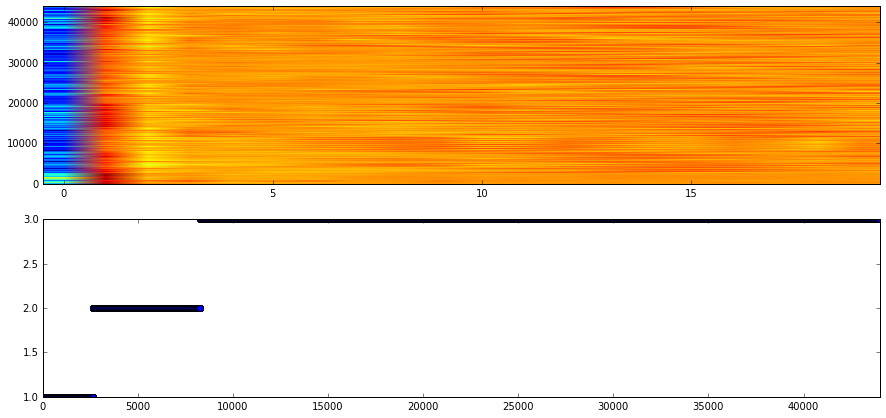

In [49]:
label_index_list = np.arange(len(label_values))
plt.figure(figsize = (15, 7))

plt.subplot(2,2,1)
plt.imshow(mfcc_matrix.T, origin = "lower")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("MFCC Coefficient")

plt.subplot(2,1,3)
plt.plot(label_matrix, "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.subplot(2,2,2)
plt.imshow(mfcc_matrix_normal.T, origin = "lower")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Standardized MFCC Coefficient")

plt.subplot(2,1,4)
plt.plot(label_matrix, "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.show()

In [50]:
clf = RandomForestClassifier(n_estimators = 10)
clf.fit(mfcc_matrix_normal, label_matrix)

from sklearn.externals import joblib
joblib.dump(clf, "instrument_classifer.pkl")


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
clf.score(mfcc_matrix_normal, label_matrix)

0.99997727221073207

In [52]:
def clf_predict(audio_fpath, clf, mfcc_means, mfcc_std):
    # normalizing volume, removing silence
    temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
    tfm = sox.Transformer()
    tfm.norm(db_level=-6)
    tfm.silence()
    tfm.build(audio_fpath, temp_fpath.name)
        
    # load audio
    y, fs = librosa.load(temp_fpath.name)
        
    # compute MFCCs
    M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)
    
    M_normal = (M - mfcc_means)/mfcc_std
    
    predicted_label = clf.predict(M_normal.T)
    